In [1]:
from __future__ import annotations
import json
from pathlib import Path
from typing import Iterable, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_logs_jsonl(paths: Union[str, Path, Iterable[Union[str, Path]]]) -> pd.DataFrame:
    """
    Read 1+ .jsonl files into a single DataFrame.
    - Accepts a path, glob pattern, or iterable of paths.
    - Ignores empty/invalid lines gracefully.
    """
    def _read_one(p: Path) -> pd.DataFrame:
        # robust reader: fall back to manual parsing if needed
        try:
            return pd.read_json(p, lines=True)
        except ValueError:
            rows = []
            with p.open("r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        rows.append(json.loads(line))
                    except json.JSONDecodeError:
                        # skip corrupt line
                        continue
            return pd.DataFrame(rows)
            # Normalize input
    if isinstance(paths, (str, Path)):
        paths = [paths]
    
    files = []
    for x in paths:
        p = Path(x)
        if any(ch in str(p) for ch in "*?[]"):  # glob
            files.extend([Path(y) for y in sorted(p.parent.glob(p.name))])
        elif p.is_dir():
            files.extend(sorted(p.rglob("*.jsonl")))
        elif p.exists():
            files.append(p)

    if not files:
        return pd.DataFrame()

    frames = [_read_one(p) for p in files]
    if not frames:
        return pd.DataFrame()
    df = pd.concat(frames, ignore_index=True)

    # Ensure expected columns exist (add if missing)
    for col in ("file_hash", "timestamp", "retries_used"):
        if col not in df.columns:
            df[col] = None

    # Parse timestamp to UTC-aware datetime if possible
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce")

    # Coerce retries to numeric for sorting tie-break
    df["retries_used"] = pd.to_numeric(df["retries_used"], errors="coerce").fillna(0).astype(int)

    return df

In [3]:
def latest_per_file(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df

    df_sorted = df.sort_values(
        by=["file_hash", "timestamp", "retries_used"],
        ascending=[True, True, True],
        kind="mergesort",  # stable
    )

    latest = df_sorted.drop_duplicates(subset=["file_hash"], keep="last").reset_index(drop=True)
    return latest


In [4]:
def normalize_token_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Inputs (prefer custom, else Google fields minus candidates if total not available)
    df["input_tokens"] = np.where(
        df.get("total_input_tokens").notna() if "total_input_tokens" in df else False,
        df.get("total_input_tokens"),
        df.get("prompt_token_count"),
    )
    df["output_tokens"] = np.where(
        df.get("total_output_tokens").notna() if "total_output_tokens" in df else False,
        df.get("total_output_tokens"),
        df.get("candidates_token_count"),
    )

    # Total: prefer explicit total, else sum of input+output, else provided total_token_count
    df["total_tokens"] = np.select(
        [
            df.get("total_tokens").notna() if "total_tokens" in df else False,
            (df.get("input_tokens").notna() & df.get("output_tokens").notna()),
        ],
        [
            df.get("total_tokens"),
            df.get("input_tokens").fillna(0) + df.get("output_tokens").fillna(0),
        ],
        default=df.get("total_token_count"),
    )
    return df

In [5]:
def print_summary(df_all: pd.DataFrame, df_latest: pd.DataFrame) -> None:
    print("------ Summary ------")
    print(f"All rows: {len(df_all)}")
    print(f"Unique files: {df_all['file_hash'].nunique() if not df_all.empty else 0}")
    print(f"Kept (latest per file): {len(df_latest)}\n")

    if df_latest.empty:
        return

    pass_rate = float(df_latest["compiled_success"].mean()) if "compiled_success" in df_latest else float("nan")
    avg_retries = float(df_latest["total_attempts_completed"].mean()) if "total_attempts_completed" in df_latest else float("nan")
    avg_latency = float(df_latest["llm_latency_ms_total"].mean()) if "llm_latency_ms_total" in df_latest else float("nan")
    avg_line_diff = float(df_latest["diff_lines"].mean()) if "diff_lines" in df_latest else float("nan")
    print(f"Pass rate: {pass_rate:.3f}")
    print(f"Avg retries: {avg_retries:.2f}")
    print(f"Avg LLM latency (ms): {avg_latency:.0f}")
    print(f"Avg Line Diff: {avg_line_diff:.2f}")

    if "bytecode_version" in df_latest:
        bb = df_latest.groupby("bytecode_version")["compiled_success"].mean().rename("pass_rate")
        print("\nPass rate by bytecode_version:\n", bb.to_string())


In [6]:
def make_plots(df_latest: pd.DataFrame) -> None:
    """Quick matplotlib plots. Close each figure after show if embedding elsewhere."""
    if df_latest.empty:
        print("No data to plot.")
        return

    # ---------- helper: generic boxplot by outcome ----------
    def _boxplot_by_outcome(df: pd.DataFrame, column: str, title: Optional[str] = None, log: bool = False) -> None:
        if "compiled_success" not in df or column not in df:
            return
        s_ok = pd.to_numeric(df.loc[df["compiled_success"] == True, column], errors="coerce").dropna()
        s_bad = pd.to_numeric(df.loc[df["compiled_success"] == False, column], errors="coerce").dropna()
        if s_ok.empty and s_bad.empty:
            return
        plt.figure()
        plt.boxplot([s_ok, s_bad], labels=["success", "failure"], showfliers=False)
        if log:
            plt.yscale("log")
        plt.title(title or f"{column} by compilation outcome")
        plt.ylabel(column)
        plt.tight_layout()
        plt.show()

    # Success vs failure counts
    if "compiled_success" in df_latest:
        counts = df_latest["compiled_success"].value_counts().rename(index={True: "success", False: "failure"})
        plt.figure()
        counts.plot(kind="bar")
        plt.title("Compilation Outcome Counts")
        plt.ylabel("Count")
        plt.xlabel("Outcome")
        plt.tight_layout()
        plt.show()

    # 1) Bar: success rate by bytecode version
    if "bytecode_version" in df_latest and "compiled_success" in df_latest:
        by_ver = df_latest.groupby("bytecode_version")["compiled_success"].mean().sort_values()
        plt.figure()
        by_ver.plot(kind="bar")
        plt.title("Pass rate by bytecode_version")
        plt.ylabel("Pass rate")
        plt.xlabel("bytecode_version")
        plt.tight_layout()
        plt.show()

    # 2) Histogram: LLM latency
    if "llm_latency_ms_total" in df_latest:
        plt.figure()
        pd.to_numeric(df_latest["llm_latency_ms_total"], errors="coerce").dropna().plot(kind="hist", bins=30)
        plt.title("LLM latency (ms)")
        plt.xlabel("ms")
        plt.tight_layout()
        plt.show()

    # 3) Boxplots split by outcome (added)
    _boxplot_by_outcome(df_latest, "total_attempts_completed", "Attempts by outcome")
    _boxplot_by_outcome(df_latest, "llm_latency_ms_total", "LLM Latency (ms) by outcome", log=False)
    # If you normalized tokens earlier (recommended), this will exist:
    if "total_tokens" in df_latest:
        _boxplot_by_outcome(df_latest, "total_tokens", "Total Tokens by outcome", log=False)
    # Diff size often skewed; a log scale can help
    if "diff_lines" in df_latest:
        _boxplot_by_outcome(df_latest, "diff_lines", "Diff Lines by outcome", log=True)
    if "compile_latency_ms" in df_latest:
        _boxplot_by_outcome(df_latest, "compile_latency_ms", "Compile Latency (ms) by outcome", log=False)

    # 4) Scatter: total_tokens vs latency
    if "total_tokens" in df_latest and "llm_latency_ms_total" in df_latest:
        plt.figure()
        sub = df_latest.dropna(subset=["total_tokens", "llm_latency_ms_total"]).copy()
        sub["total_tokens"] = pd.to_numeric(sub["total_tokens"], errors="coerce")
        sub["llm_latency_ms_total"] = pd.to_numeric(sub["llm_latency_ms_total"], errors="coerce")
        sub = sub.dropna(subset=["total_tokens", "llm_latency_ms_total"])
        plt.scatter(sub["total_tokens"], sub["llm_latency_ms_total"], alpha=0.6)
        plt.title("Latency vs Total Tokens")
        plt.xlabel("total_tokens")
        plt.ylabel("llm_latency_ms_total (ms)")
        plt.tight_layout()
        plt.show()

    # 5) Top failure types
    if "compiled_success" in df_latest and "compile_error_type_after" in df_latest:
        fails = df_latest.loc[df_latest["compiled_success"] == False, "compile_error_type_after"].fillna("Unknown")
        if not fails.empty:
            top = fails.value_counts().head(10)
            plt.figure()
            top.plot(kind="bar")
            plt.title("Top failure types (latest per file)")
            plt.ylabel("count")
            plt.tight_layout()
            plt.show()


In [7]:
import shutil
import os
from pathlib import Path
import pandas as pd

def copy_directory_contents(df: pd.DataFrame, dest_base_dir: str) -> None:
    dest_base_path = Path(dest_base_dir)
    dest_base_path.mkdir(parents=True, exist_ok=True)

    for idx, row in df.iterrows():
        file_hash = row["file_hash"]
        src_dir = Path(f"../decompiler_workspace/{file_hash}")
        dest_dir = dest_base_path / file_hash

        if src_dir.exists() and src_dir.is_dir():
            print(f"Copying files from {src_dir} to {dest_dir}...")
            dest_dir.mkdir(parents=True, exist_ok=True)

            for item in src_dir.iterdir():
                dest_item = dest_dir / item.name
                if item.is_dir():
                    shutil.copytree(item, dest_item)
                else:
                    shutil.copy(item, dest_item)

            print(f"Successfully copied files for file_hash: {file_hash}")
        else:
            print(f"Source directory for file_hash {file_hash} does not exist.")

In [8]:
# Set your destination directory
# destination_directory = "../experiment_latest_outputs/affected_files/"
# copy_directory_contents(df_latest, destination_directory)

In [9]:
df_all = load_logs_jsonl("results/experiment_outputs/20251110T012915Z/daf95c71075048e1b3458c3c109344fd/run_log_daf95c71075048e1b3458c3c109344fd.jsonl")
# df_all = normalize_token_cols(df_all)
# df_latest = latest_per_file(df_all)

# print_summary(df_all, df_latest)
# make_plots(df_latest)

In [10]:
# def get_duplicates(df: pd.DataFrame) -> pd.DataFrame:
#     # Find duplicates based on 'file_hash'
#     # Keep all rows that have a duplicate value of 'file_hash'
#     duplicate_rows = df[df.duplicated('file_hash', keep=False)]
    
#     return duplicate_rows


In [11]:
# def get_filtered_duplicates(df: pd.DataFrame) -> pd.DataFrame:
#     # Find duplicates based on 'file_hash'
#     duplicate_rows = df[df.duplicated('file_hash', keep=False)]
    
#     # Filter out rows where 'compiled_success' is False, and both 'compile_error_word_after' and 'compile_error_description_after' are null
#     filtered_duplicates = duplicate_rows[
#         ~((duplicate_rows['compiled_success'] == False) & 
#            (duplicate_rows['compile_error_word_after'].isna()) & 
#            (duplicate_rows['compile_error_message_after'].isna()))
#     ]
    
#     return filtered_duplicates


In [12]:
# # Assuming you already have a DataFrame like `df_syntax_error_balanced`
# df_duplicates = get_filtered_duplicates(df_all)

# # This will show all rows with duplicate 'file_hash'
# print(len(df_duplicates))


In [13]:
# df_cleaned = remove_filtered_duplicates(df_all)

In [14]:
# print(len(df_cleaned))

------ Summary ------
All rows: 352
Unique files: 352
Kept (latest per file): 352

Pass rate: 0.974
Avg retries: 1.68
Avg LLM latency (ms): 50527
Avg Line Diff: 146.00

Pass rate by bytecode_version:
 bytecode_version
3.12    0.974432


/tmp/ipykernel_3002076/2023909768.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.get("input_tokens").fillna(0) + df.get("output_tokens").fillna(0),


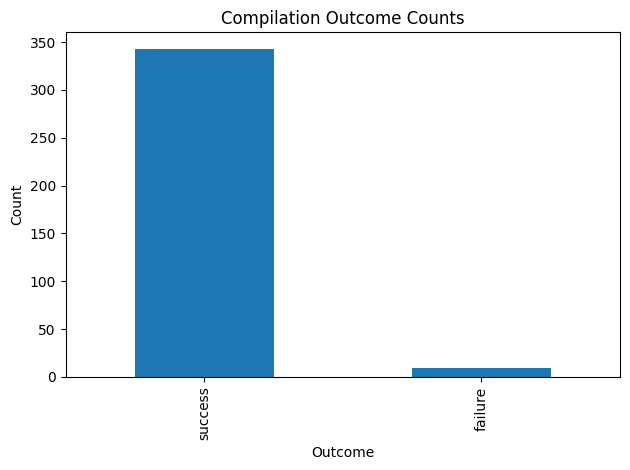

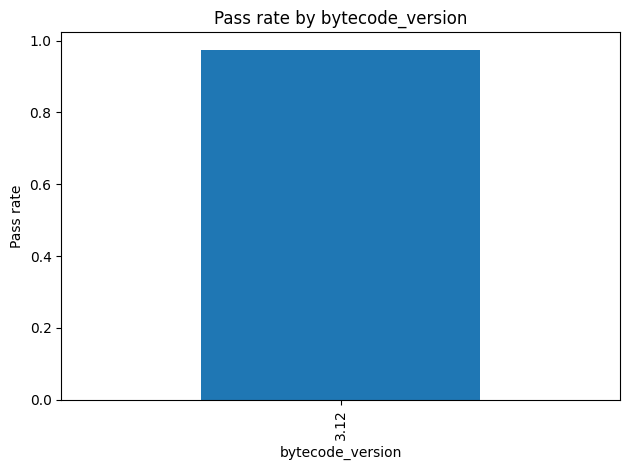

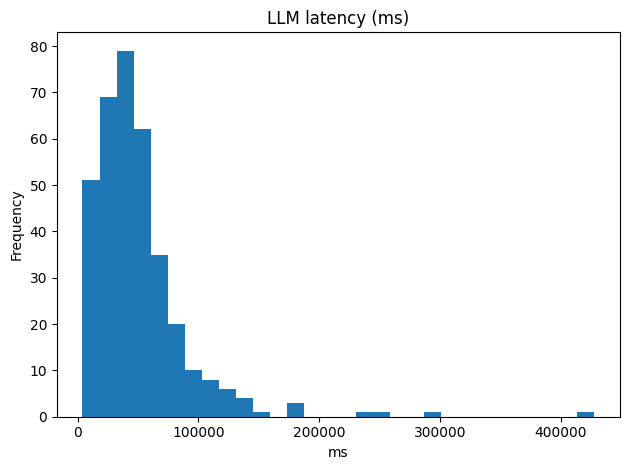

/tmp/ipykernel_3002076/1620598653.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([s_ok, s_bad], labels=["success", "failure"], showfliers=False)


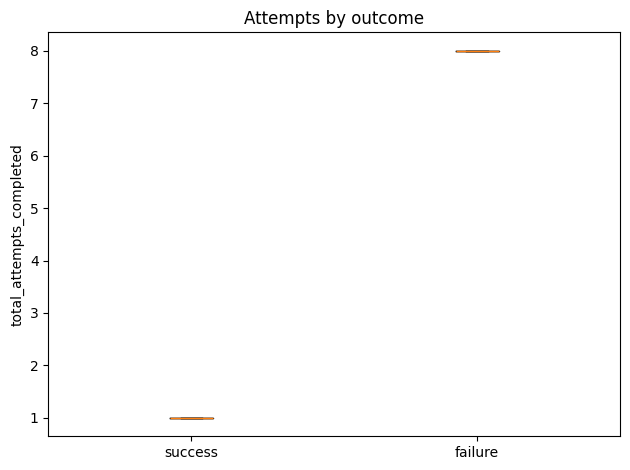

/tmp/ipykernel_3002076/1620598653.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([s_ok, s_bad], labels=["success", "failure"], showfliers=False)


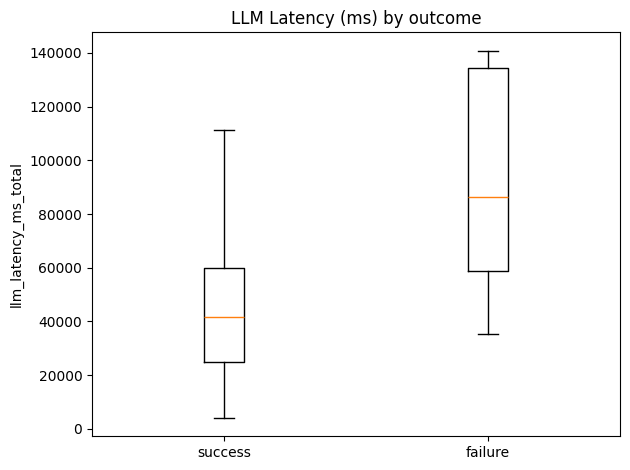

/tmp/ipykernel_3002076/1620598653.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([s_ok, s_bad], labels=["success", "failure"], showfliers=False)


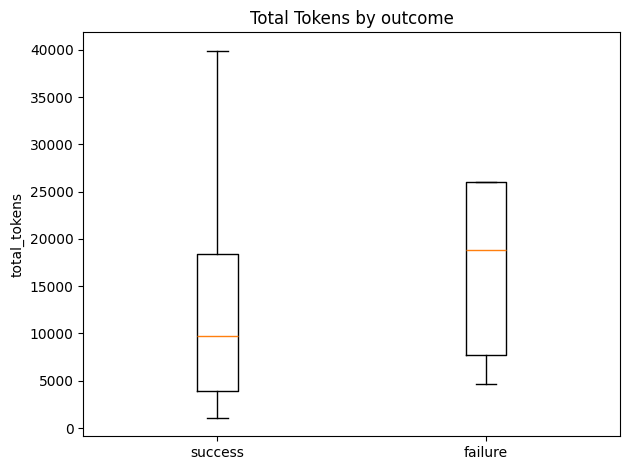

/tmp/ipykernel_3002076/1620598653.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([s_ok, s_bad], labels=["success", "failure"], showfliers=False)


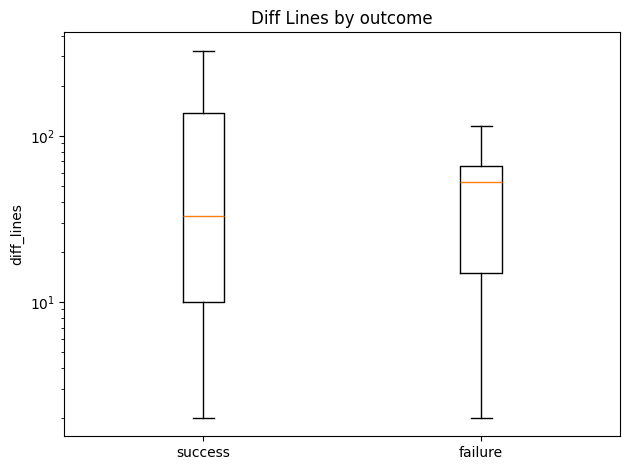

/tmp/ipykernel_3002076/1620598653.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([s_ok, s_bad], labels=["success", "failure"], showfliers=False)


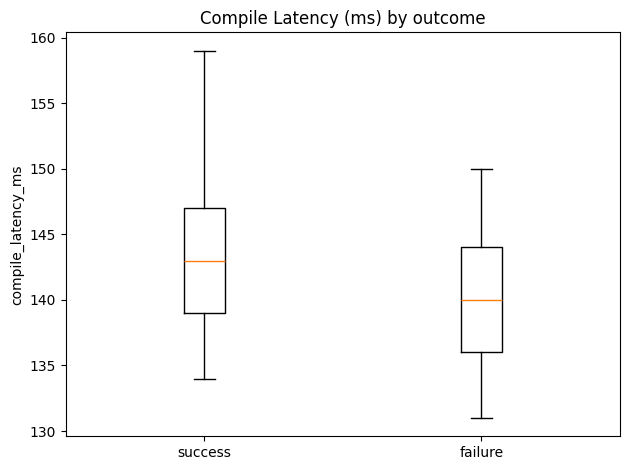

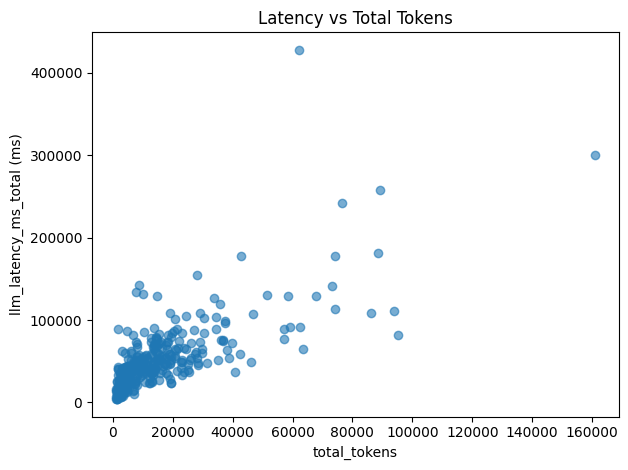

In [15]:
df_cleaned = normalize_token_cols(df_all)
df_latest = latest_per_file(df_cleaned)

print_summary(df_cleaned, df_latest)
make_plots(df_latest)

In [16]:
# df_cleaned.to_csv("results/experiment_outputs/20251008T033843Z/2f7caecbbb20418dbc951c146b04fb4a/results_with_3_tries.csv", index=False)